In [1]:
##################################
#
# Implementation of the Linear Logic Recurrent Neural Network (LLRNN)
#

###################
# HYPERPARAMETERS #
###################

use_model             = 'ntm' # ntm, pattern_ntm
task                  = 'copy' # copy, repeat copy, pattern i 
epoch                 = 100 # number of training epochs, default to 100
num_classes           = 10 # number of symbols, INCLUDING initial and terminal symbols
N                     = 30 # length of input sequences for training, default to 20, INCLUDING initial and terminal symbols
Ntest                 = 35 # length of sequences for testing, default to N, INCLUDING initial and terminal symbols
batch_size            = 250 # default 250
controller_state_size = 100 # dimension of the internal state space of the controller, default 100
LOG_DIR               = '/tmp/log' # default /tmp/log
num_training          = 250 # default 10000
num_test              = num_training
init_symbol           = num_classes - 2
term_symbol           = num_classes - 1
seq_length_min        = 4

##################
# MODEL SPECIFIC #
##################

ntm_memory_address_size   = 128 # number of memory locations, default 128
ntm_memory_content_size   = 20 # size of vector stored at a memory location, default 20
ntm_powers                = [0,-1,1] # powers of R used by controller, default [0,-1,1]

pattern_ntm_powers               = [[0,-1,1],[0,-1,1]] # powers used by controller on each ring resp.
pattern_ntm_powers_2_on_1        = [0,2,4] # allowed powers used by ring 2 to manipulate ring 1
pattern_ntm_memory_address_sizes = [128, 128] # number of memory locations for the three rings
pattern_ntm_memory_content_sizes = [20, len(pattern_ntm_powers_2_on_1)] # size of content vector for each ring
pattern_ntm_direct_bias          = 1.0

##########
# NOTES
#
# 1. Always put the zero power first in powers_ring since the code assumes this is there
# 2. The initial and terminal symbols are always from the end of the list of symbols, so they
# are respectively num_classes - 2 and num_classes - 1. So the number of symbols which are
# not initial or terminal is num_classes - 2

In [2]:
%matplotlib notebook

# The next three lines are recommend by TF
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas
import collections
import six
import math
import time
import random

from tensorflow.python.ops.rnn_cell_impl import _RNNCell as RNNCell
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh

# Our libraries
import ntm
import seqhelper
import learnfuncs

In [3]:
#######################
# SETUP TASKS
#
# Our sequences are of one-hot vectors, which we interpret as follows:
#
# [1.0, 0.0, 0.0] = 0
# [0.0, 1.0, 0.0] = 1
# [0.0, 0.0, 1.0] = 2 etc
#
# We write our sequences and functions referring to sequences of integers,
# and then convert to one-hot vectors for integration with TF.

# Below N_out and Ntest_out are the lengths of the outputs in both the training
# and testing regimes respectively. Since outputs do not include the initial and terminal
# symbols, these default to N - 2 and Ntest - 2 respectively.

###########
# COPY TASK
if( task == 'copy' ):
    func_to_learn = learnfuncs.f_identity
    N_out = N - 2
    Ntest_out = Ntest - 2

##################
# REPEAT COPY TASK
# put n zeros before the 1, for a copy task with n + 1 copies
if( task == 'repeat copy' ):
    no_of_copies = 2
    pattern = [0]*(no_of_copies - 1) + [1]
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = no_of_copies * (N - 2)
    Ntest_out = no_of_copies * (Ntest - 2)

################
# PATTERN TASK 1
if( task == 'pattern 1' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,1,1] # so (a,b,c,d,e,f,...) goes to (a,a,b,c,c,d,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = (N - 2) + divmod(N - 2, 2)[0] # N - 2 plus the number of times 2 divides N - 2
    Ntest_out = (Ntest - 2) + divmod(Ntest - 2, 2)[0]

################
# PATTERN TASK 2
if( task == 'pattern 2' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2] # so (a,b,c,d,e,f,...) goes to (a,a,c,c,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = N - 2 + divmod(N - 2, 2)[0]
    Ntest_out = Ntest - 2 + divmod(Ntest - 2, 2)[0]
    
################
# PATTERN TASK 3
if( task == 'pattern 3' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2,-1] # so (a,b,c,d,e,f,...) goes to (a,a,c,b,b,d,c,c,e,d,d,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = 4 + (N - 2 - 2) * 3
    Ntest_out = 4 + (Ntest - 2 - 2) * 3

################
# PATTERN TASK 4
if( task == 'pattern 4' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2,1,2,-2,-1] # so (a,b,c,d,e,f,...) goes to (a,a,c,d,f,d,c,c,e,f,h,f,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = len(func_to_learn([0]*(N-2)))
    Ntest_out = len(func_to_learn([0]*(Ntest-2)))

# Give an example input/output pair
a = [random.randint(0,num_classes-3) for i in range(N - 2)]
fa = func_to_learn(a)

print("Under the chosen function, the sequence")
print(a)
print("is mapped to")
print(fa)

Under the chosen function, the sequence
[7, 4, 3, 0, 3, 1, 0, 6, 2, 0, 1, 3, 2, 4, 4, 4, 0, 7, 4, 5, 2, 0, 2, 3, 7, 0, 3, 5]
is mapped to
[7, 4, 3, 0, 3, 1, 0, 6, 2, 0, 1, 3, 2, 4, 4, 4, 0, 7, 4, 5, 2, 0, 2, 3, 7, 0, 3, 5]


In [4]:
####################
# INITIALISE STATE #
####################

one_hots = seqhelper.one_hot_vectors(num_classes)
input_size = num_classes # dimension of the input space I
state_size = 0

#####
# NTM

def init_state_ntm(batch_size, css, mas, mcs):
    state_size = css + 2*mas + mas * mcs
    
    ra = [0.0]*mas
    ra[0] = 1.0
    batch_address = np.zeros([batch_size,mas]) + ra
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    init_read_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_write_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_memory = tf.truncated_normal([batch_size, mas*mcs], 0.0, 1e-6, dtype=tf.float32)
    
    state = tf.concat([init_controller_state,init_read_address,init_write_address,init_memory],1)
    return state_size, state

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size, ntm_memory_address_size, ntm_memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,ntm_memory_address_size,ntm_memory_content_size, ntm_powers)

#############
# PATTERN NTM

def init_state_pattern_ntm(batch_size, css, mas, mcs):
    # mas and mcs are arrays of address sizes and content sizes for rings
    state_size = css
    
    init_address = []
    
    for i in range(len(mas)):
        state_size = state_size + mas[i] * mcs[i] # for memory vector
        state_size = state_size + 2 * mas[i] # for addresses (read and write)
    
        ra = [0.0]*mas[i]
        ra[0] = 1.0
        init_address.append(np.zeros([batch_size,mas[i]]) + ra)
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    
    tensor_list = [init_controller_state]
    
    for i in range(len(mas)):
        init_read_address = tf.constant(init_address[i],dtype=tf.float32,shape=[batch_size,mas[i]])
        init_write_address = tf.constant(init_address[i],dtype=tf.float32,shape=[batch_size,mas[i]])
        tensor_list = tensor_list + [init_read_address,init_write_address]
        
    for i in range(len(mas)):
        init_memory = tf.truncated_normal([batch_size, mas[i]*mcs[i]], 0.0, 1e-6, dtype=tf.float32)
        tensor_list = tensor_list + [init_memory]
    
    state = tf.concat(tensor_list,1)
    
    return state_size, state

if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, pattern_ntm_memory_address_sizes, 
                                               pattern_ntm_memory_content_sizes)
    cell = ntm.PatternNTM(state_size, input_size, controller_state_size, pattern_ntm_memory_address_sizes,
                          pattern_ntm_memory_content_sizes, pattern_ntm_powers, pattern_ntm_powers_2_on_1, pattern_ntm_direct_bias)
    

In [5]:
################
# DEFINE MODEL #
################

inputs = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]
targets = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]

# Used in order to flag that we share weights across iterations.
# Note that the training and test phases use all the same weights.
reuse = False

# Set up training graph
read_addresses = []
write_addresses = []
read_addresses2 = []
write_addresses2 = []
interps = []
rnn_outputs = []
m2 = []
    
for i in range(N + N_out):
    # Logging
    if( use_model == 'ntm' ):
        h0, curr_read, curr_write, _ = tf.split(state, [controller_state_size,ntm_memory_address_size,
                                                        ntm_memory_address_size,-1], 1)

    if( use_model == 'pattern_ntm' ):
        h0, curr_read, curr_write, curr_read2, curr_write2, m1_state , m2_state = tf.split(state, [controller_state_size,
                            pattern_ntm_memory_address_sizes[0],pattern_ntm_memory_address_sizes[0],
                            pattern_ntm_memory_address_sizes[1],pattern_ntm_memory_address_sizes[1],
                            pattern_ntm_memory_address_sizes[0] * pattern_ntm_memory_content_sizes[0],
                            pattern_ntm_memory_address_sizes[1] * pattern_ntm_memory_content_sizes[1]], 1)

    #### RUN MODEL ####
    output, state = cell(inputs[i],state,'NTM',reuse)
    rnn_outputs.append(output)
    ###################
    
    # More logging
    read_addresses.append(curr_read[0,:])
    write_addresses.append(curr_write[0,:])
    
    if( use_model == 'pattern_ntm' ):
        read_addresses2.append(curr_read2[0,:])
        write_addresses2.append(curr_write2[0,:])
        m2_state = tf.reshape(m2_state, [-1,pattern_ntm_memory_address_sizes[1],pattern_ntm_memory_content_sizes[1]])
        m2.append(m2_state[0,:])

        with tf.variable_scope("NTM",reuse=True):
            W_interp = tf.get_variable("W_interp", [controller_state_size,1])
            B_interp = tf.get_variable("B_interp", [1])
            interp = tf.sigmoid(tf.matmul(h0,W_interp) + B_interp)
            interp_matrix = tf.concat([interp,tf.ones_like(interp,dtype=tf.float32) - interp],axis=1) # shape [-1,2]
            interps.append(interp_matrix[0,:])

    reuse = True

# Final fully connected layer
with tf.variable_scope("final_layer"):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size],initializer=init_ops.constant_initializer(0.0))

# Note: prediction is a length N list of tensors of shape [None,input_size], where
# the jth row of prediction[d] is, for the jth input sequence in the batch,
# the probability distribution over symbols for the output symbol in position d.

# Note: We allow the length of input sequences to vary between batches, which means
# that the cross entropy needs to be masked to the relevant part of the output

# Note: we use log_softmax to avoid precision issues with floats causing log(0) to create NaNs

logits = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs]
prediction = [tf.nn.log_softmax(logit) for logit in logits] 
ce = [tf.reduce_sum(targets[i] * prediction[i]) for i in range(N + N_out)] # an array of numbers
mask = [tf.sign(tf.reduce_max(tf.abs(targets[i]))) for i in range(N + N_out)]
ce_mask = [ce[i] * mask[i] for i in range(N + N_out)]
cross_entropy = -tf.add_n(ce_mask)
cross_entropy /= tf.add_n(mask) # DEBUG do we really need this?
# NOTE: here in creating the mask we are assuming that batches have the same sequence length
                    
optimizer = tf.train.RMSPropOptimizer(1e-4,decay=0.9,momentum=0.9)
minimize = optimizer.minimize(cross_entropy)
mistakes = [tf.not_equal(tf.argmax(targets[i], 1), tf.argmax(prediction[i], 1)) for i in range(N + N_out)]
errors = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes]

# Summaries
errors_mask = [errors[i] * mask[i] for i in range(N + N_out)]
mean_error = tf.add_n(errors_mask)
mean_error /= tf.add_n(mask)
tf.summary.scalar('error', mean_error)

# Initialise the model
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

merged_summaries = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

[<tf.Tensor 'gradients/NTM_114/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_112/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_110/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_108/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_106/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_104/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_102/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_100/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_98/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_96/split_grad/concat:0' shape=(250, 3556) dtype=float32>, None, None]
[<tf.Tensor 'gradients

In [6]:
############
# TRAINING #
############

random.seed()

pre_train_time = time.time()

# Training
no_of_batches = int(num_training/batch_size)

###################
# Note on sequences
#
# Our sequences are of varying length, in the alphabet {0,...,num_classes - 3}.
# Each input sequence begins with an initial symbol and ends with a terminal symbol
# (the value of which are num_classes - 2 and num_classes - 1 by default). Output
# sequences do not have either an initial nor a terminal symbol.
#
# Both input and output sequences are written on a "tape" of length N + N_out.
# Input sequences are aligned at the BEGINNING of the tape, and all remaining space
# is filled with terminal symbols. Output sequences are aligned at the END OF THE 
# MATCHING INPUT, with all remaining space filled with zero vectors.
#
# Example: suppose N = N_out = 10, and num_classes = 10 so that init_symbol = 8
# and term_symbol = 9. Then a sequence of length 8 (seq_length = 10 below) is
#
# a = [4, 4, 5, 6, 3, 3, 6, 7]
#
# which written on the tape is
#
# [8, 4, 4, 5, 6, 3, 3, 6, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
#
# If we are performing the copy task, so that the output sequence is also a, then
# the output written on the tape will be (notice the alignment)
#
# [-, -, -, -, -, -, -, -, -, 4, 4, 5, 6, 3, 3, 6, 7, -, -, -]
#
# where - is a symbol whose encoding is the zero vector.

error_means = []

for i in range(epoch):
    for j in range(no_of_batches):
        inp = []
        out = []

        # We sample each batch on the fly from the set of all sequences. Each
        # batch has a fixed length of the sequences. Recall that all input seqs
        # have an initial and terminal symbol, so if seq_length = 10 then there
        # are eight positions for the "content" symbols
        seq_length = random.randint(seq_length_min,N)
        
        for z in range(batch_size):
            a = [random.randint(0,num_classes-3) for k in range(seq_length-2)]
            fa = func_to_learn(a)
            a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(N+N_out-seq_length)]
            a_onehot = [one_hots[e] for e in a]
            fa_onehot = [[0.0]*num_classes for k in range(seq_length-1)] + \
                        [one_hots[e] for e in fa] + \
                        [[0.0]*num_classes for k in range(N+N_out-(seq_length-1)-len(fa))]
            inp.append(np.array(a_onehot))
            out.append(np.array(fa_onehot))        
        
        # An annoying thing here is that we cannot use a list as a key in a 
        # dictionary. The workaround we found on StackOverflow here:
        # http://stackoverflow.com/questions/33684657/issue-feeding-a-list-into-feed-dict-in-tensorflow)
        feed_dict = {}
        for d in range(N + N_out):
            in_node = inputs[d]
            # inp has dimensions [batch_size, N, num_classes] and we want to extract
            # the 2D Tensor of shape [batch_size, num_classes] obtained by setting the
            # second coordinate to d
            ti = []
            for k in range(batch_size):
                ti.append(inp[k][d])
            feed_dict[in_node] = np.array(ti)

        for d in range(N + N_out):
            out_node = targets[d]
            to = []
            for k in range(batch_size):
                to.append(out[k][d])
            feed_dict[out_node] = np.array(to)
        
        # for the first batch in an epoch, we have some logging
        if( j == 0 and i % 25 == 0 ):
            r1_val, w1_val = sess.run([read_addresses,write_addresses],feed_dict)
            
            if( use_model == 'pattern_ntm' ):
                r2_val, w2_val = sess.run([read_addresses2,write_addresses2],feed_dict)
                interps_val = sess.run(interps,feed_dict)
                m2_val = sess.run(m2,feed_dict)
                
            s = 0
            for r in range(len(w1_val)):
                print_str = " Step " + str(s) + " r [" + str(r1_val[r].argmax()) + "]" + \
                            " w [" + str(w1_val[r].argmax()) + "]"
                    
                if( use_model == 'pattern_ntm' ):
                    print_str = print_str + " r2 [" + str(r2_val[r].argmax()) + "]" + \
                          " w2 [" + str(w2_val[r].argmax()) + "]" + \
                          " interp " + str(interps_val[r])     
                    
                print(print_str)
                
                #if( r == len(write_addresses_val) - 1 ):
                #    print("Write address -")
                #    print(write_addresses_val[r])               
                                            
                s = s + 1
        
        ##### Do gradient descent #####
        #summary,mean_error_val,_ = sess.run([merged_summaries,mean_error,minimize], feed_dict)
        mean_error_val,_ = sess.run([mean_error,minimize], feed_dict)
        # DEBUG: does computing the mean error for every batch slow down training too much?
        ########
        
        error_means.append(mean_error_val)
        
        # Write out TensorBoard logs
        #file_writer.add_summary(summary)
    
    # Print the mean error of the final batch in the epoch
    print("Epoch - " + str(i+1) + ", length - " + str(seq_length - 2) + ", error - " + str(mean_error_val))
    
# Write out variables to disk
saver = tf.train.Saver()
save_path = saver.save(sess,"/tmp/model.ckpt")
sess.close()

print("")
print("It took", time.time() - pre_train_time, "seconds to train.")

 Step 0 r [0] w [0] r2 [0] w2 [0] interp [ 0.7310586  0.2689414]
 Step 1 r [127] w [0] r2 [1] w2 [127] interp [ 0.719046  0.280954]
 Step 2 r [0] w [0] r2 [0] w2 [0] interp [ 0.68746161  0.31253839]
 Step 3 r [0] w [0] r2 [0] w2 [0] interp [ 0.70108038  0.29891962]
 Step 4 r [0] w [0] r2 [0] w2 [0] interp [ 0.77207118  0.22792882]
 Step 5 r [0] w [0] r2 [1] w2 [0] interp [ 0.74218023  0.25781977]
 Step 6 r [0] w [0] r2 [0] w2 [0] interp [ 0.74060887  0.25939113]
 Step 7 r [0] w [1] r2 [0] w2 [0] interp [ 0.75495654  0.24504346]
 Step 8 r [0] w [1] r2 [0] w2 [0] interp [ 0.78831166  0.21168834]
 Step 9 r [0] w [1] r2 [0] w2 [0] interp [ 0.78446305  0.21553695]
 Step 10 r [0] w [1] r2 [0] w2 [0] interp [ 0.69970703  0.30029297]
 Step 11 r [0] w [1] r2 [0] w2 [0] interp [ 0.75421494  0.24578506]
 Step 12 r [0] w [2] r2 [1] w2 [0] interp [ 0.80708635  0.19291365]
 Step 13 r [0] w [2] r2 [0] w2 [0] interp [ 0.78204125  0.21795875]
 Step 14 r [0] w [2] r2 [1] w2 [0] interp [ 0.78791457  0.21

<IPython.core.display.Javascript object>


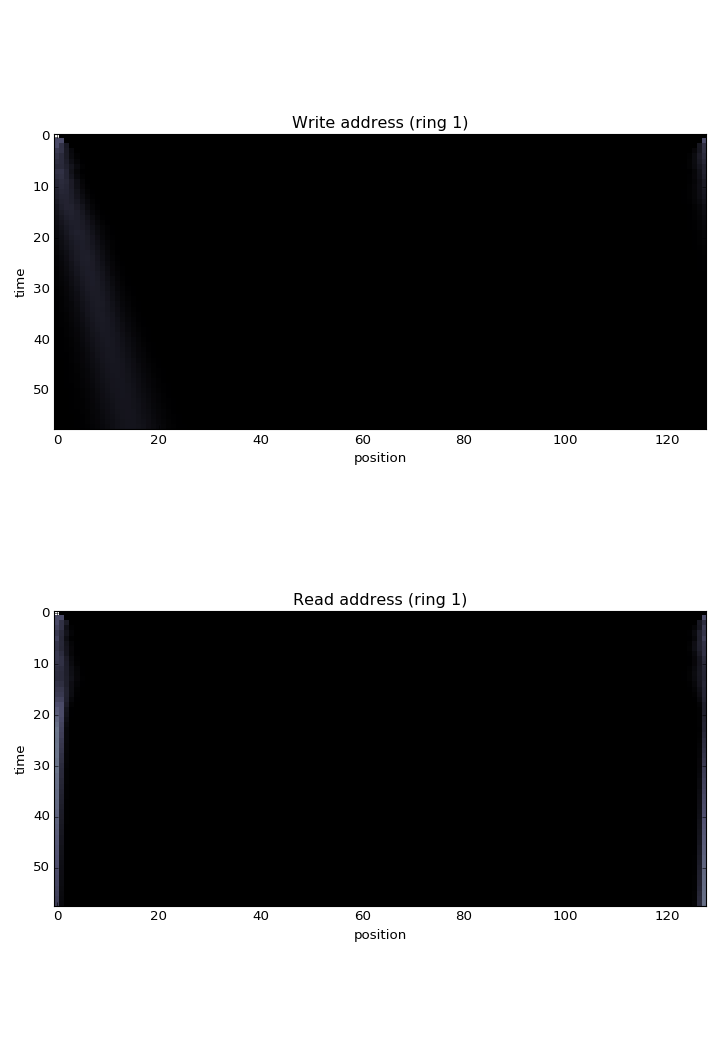

<IPython.core.display.Javascript object>


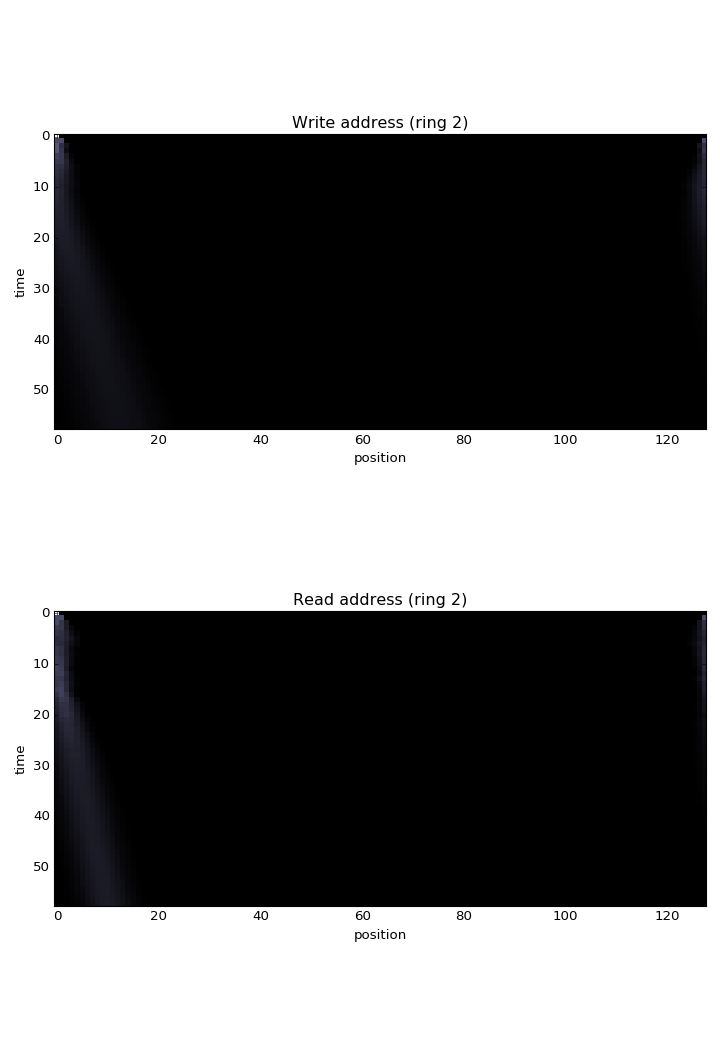

<IPython.core.display.Javascript object>


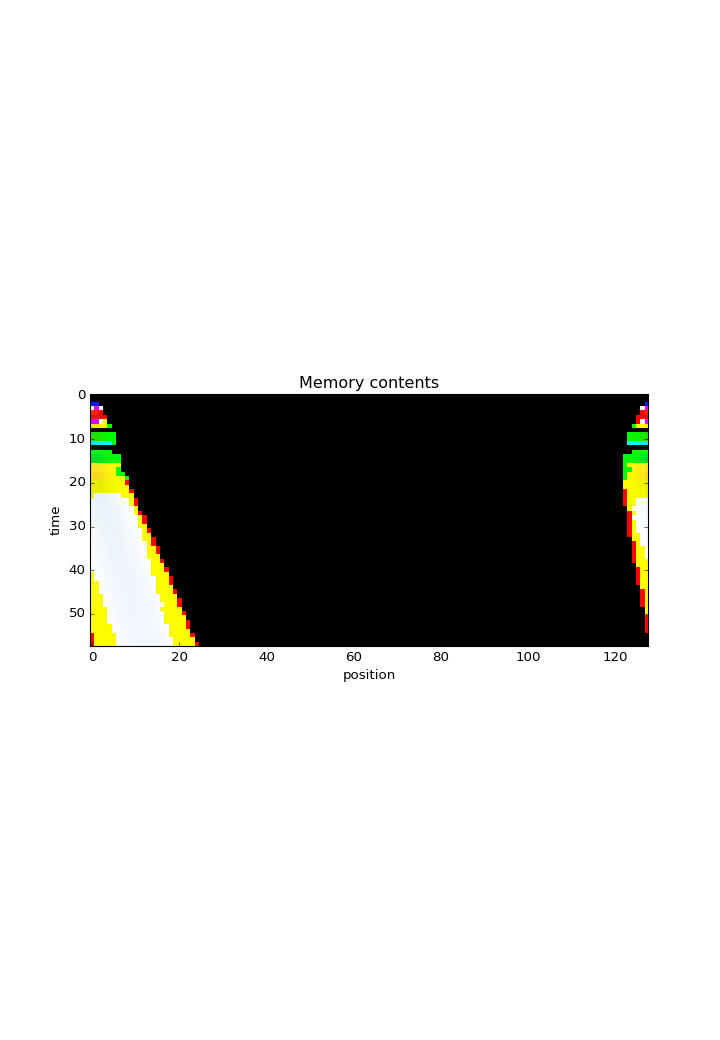

<IPython.core.display.Javascript object>


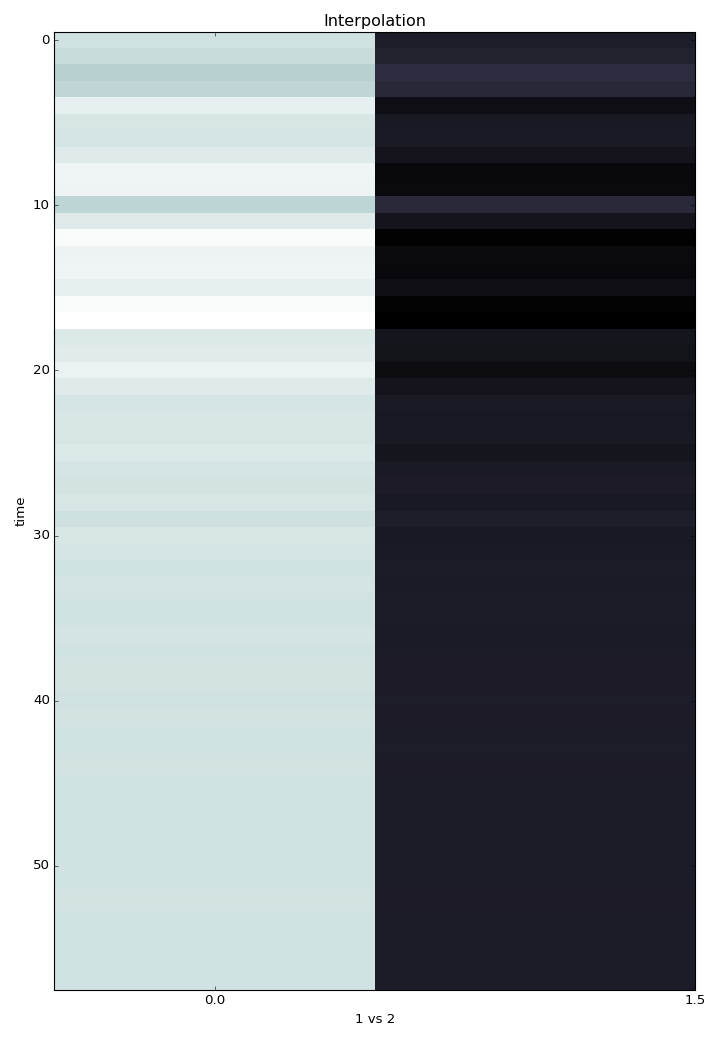

<IPython.core.display.Javascript object>


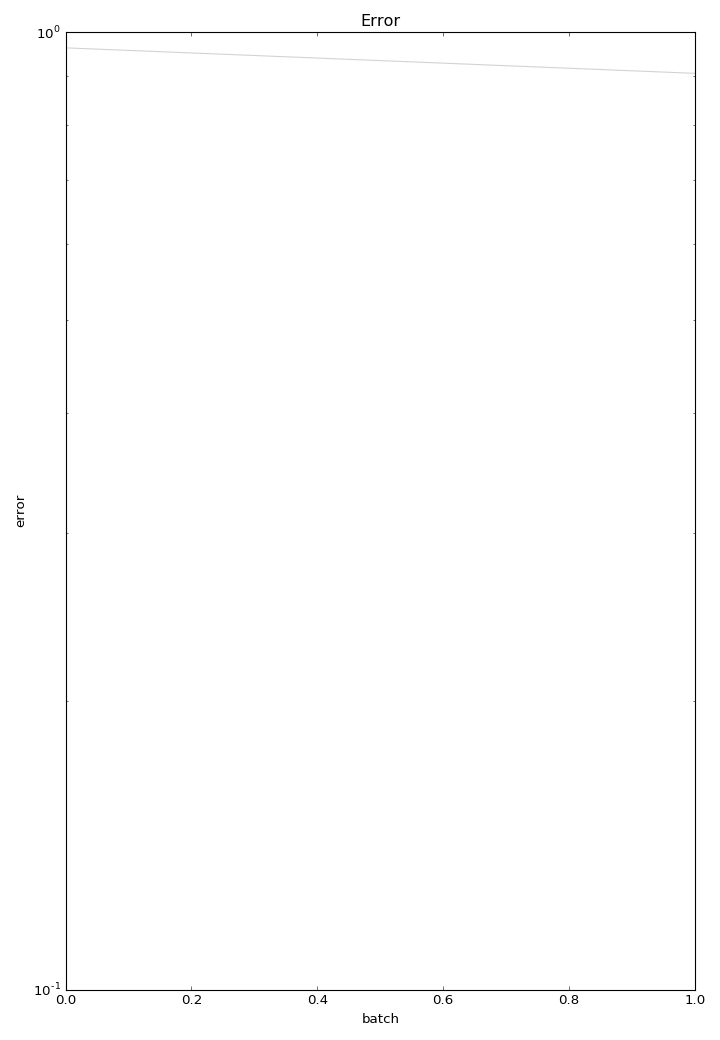

In [7]:
##################
# VISUALISATIONS #
##################

pylab.rcParams['figure.figsize'] = 9, 13

fig_num = 1
plt.figure(fig_num)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.imshow(np.stack(w1_val), cmap='bone', interpolation='nearest', aspect='equal')
ax1.set_title('Write address (ring 1)')
ax1.set_xlabel('position')
ax1.set_ylabel('time')

ax2.imshow(np.stack(r1_val), cmap='bone', interpolation='nearest', aspect='equal')
ax2.set_title('Read address (ring 1)')
ax2.set_xlabel('position')
ax2.set_ylabel('time')
plt.tight_layout()

if( use_model == 'pattern_ntm' ):
    fig_num = fig_num + 1
    
    plt.figure(fig_num)
    ax3 = plt.subplot(2,1,1)
    ax4 = plt.subplot(2,1,2)

    ax3.imshow(np.stack(w2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax3.set_title('Write address (ring 2)')
    ax3.set_xlabel('position')
    ax3.set_ylabel('time')

    ax4.imshow(np.stack(r2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax4.set_title('Read address (ring 2)')
    ax4.set_xlabel('position')
    ax4.set_ylabel('time')
    plt.tight_layout()

    # Assume that powers2_on_1 has three entries we can use as colour channels
    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax6 = plt.subplot(1,1,1)    
    ax6.imshow(np.stack(m2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax6.set_title('Memory contents')
    ax6.set_xlabel('position')
    ax6.set_ylabel('time')

    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax5 = plt.subplot(1,1,1)
    
    max_xticks = 2
    xloc = plt.MaxNLocator(max_xticks)

    ax5.imshow(np.stack(interps_val), cmap='bone', interpolation='nearest', aspect='auto')
    ax5.set_title('Interpolation')
    ax5.set_xlabel('1 vs 2')
    ax5.set_ylabel('time')
    ax5.xaxis.set_major_locator(xloc)
    
    plt.tight_layout()

fig_num = fig_num + 1

plt.figure(fig_num)
ax = plt.subplot(1,1,1)
sc = pandas.Series(error_means)
ma = sc.rolling(window=500).mean()
ax.plot(sc.index, sc, color='lightgray')
ax.plot(ma.index, ma, color='red')
ax.set_yscale('log')
ax.set_xlim(sc.index.min(), sc.index.max())
ax.set_title('Error')
ax.set_xlabel('batch')
ax.set_ylabel('error')

plt.tight_layout()
plt.show()

In [8]:
###########
# TESTING #
###########

# Restore the weights from training
sess = tf.Session()
saver.restore(sess,save_path)

inputs_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]
targets_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size, ntm_memory_address_size, ntm_memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,ntm_memory_address_size,ntm_memory_content_size, ntm_powers)


if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, pattern_ntm_memory_address_sizes, 
                                               pattern_ntm_memory_content_sizes)
    cell = ntm.PatternNTM(state_size, input_size, controller_state_size, pattern_ntm_memory_address_sizes,
                          pattern_ntm_memory_content_sizes, pattern_ntm_powers, pattern_ntm_powers_2_on_1, pattern_ntm_direct_bias)

# Set up test graph
rnn_outputs_test = []
reuse = True
for i in range(Ntest + Ntest_out):
    output, state = cell(inputs_test[i],state,'NTM',reuse)
    rnn_outputs_test.append(output)

with tf.variable_scope("final_layer",reuse=True):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size])

logits_test = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs_test]
prediction_test = [tf.nn.log_softmax(logit) for logit in logits_test] 
mask = [tf.sign(tf.reduce_max(tf.abs(targets_test[i]))) for i in range(Ntest + Ntest_out)]
mistakes_test = [tf.not_equal(tf.argmax(targets_test[i], 1), tf.argmax(prediction_test[i], 1)) for i in range(Ntest + Ntest_out)]
errors_test = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes_test]
errors_test_mask = [errors_test[i] * mask[i] for i in range(Ntest + Ntest_out)]
mean_error_test = tf.add_n(errors_test_mask)
mean_error_test /= tf.add_n(mask)

#### RUN TEST ####

no_of_batches = int(num_test/batch_size)

seq_length = Ntest
print("Testing on sequences of length " + str(seq_length-2))
print("")

error_means = []
for j in range(no_of_batches):
    inp = []
    out = []

    for z in range(batch_size):
        a = [random.randint(0,num_classes-3) for k in range(seq_length-2)]        
        fa = func_to_learn(a)
        a = [init_symbol] + a + [term_symbol] + [term_symbol for k in range(Ntest+Ntest_out-seq_length)]            
        a_onehot = [one_hots[e] for e in a]
                            
        fa_onehot = [[0.0]*num_classes for k in range(seq_length-1)] + \
                    [one_hots[e] for e in fa] + \
                    [[0.0]*num_classes for k in range(Ntest+Ntest_out-(seq_length-1)-len(fa))]
        
        inp.append(np.array(a_onehot))
        out.append(np.array(fa_onehot))        
        
    feed_dict = {}
    for d in range(Ntest + Ntest_out):
        in_node = inputs_test[d]
        ti = []
        for k in range(batch_size):
            ti.append(inp[k][d])
        feed_dict[in_node] = np.array(ti)

    for d in range(Ntest + Ntest_out):
        out_node = targets_test[d]
        to = []
        for k in range(batch_size):
            to.append(out[k][d])
        feed_dict[out_node] = np.array(to)
            
    current_mean = sess.run(mean_error_test, feed_dict)
    error_means.append(current_mean)
    print("Batch - " + str(j+1) + ", Mean error - " + str(current_mean))

final_error = np.mean(error_means)

print("")        
print("###########")
print("# Summary #")
print("###########")
print("")
print("model         - " + use_model)
print("task name     - " + task)
print("epochs        - " + str(epoch))
print("num_classes   - " + str(num_classes))
print("N             - " + str(N))
#print("N_out         - " + str(N_out))
print("Ntest         - " + str(Ntest))
#print("Ntest_out     - " + str(Ntest_out))
#print("# weights     - " + str(ntm.count_number_trainable_params()))
#print("(css,mas,mcs) - (" + str(controller_state_size) + "," + str(memory_address_size) + "," + str(memory_content_size) + ")")
#print("train percent - " + str(training_percent))
print("num_training  - " + str(num_training)) #+ "/" + str((num_classes-2)**(N-2)))
print("num_test      - " + str(num_test)) #+ "/" + str((num_classes-2)**(N-2)))
print("")
print("")
print("error         - " + str(final_error))
sess.close()

Testing on sequences of length 33

Batch - 1, Mean error - 0.880121

###########
# Summary #
###########

model         - pattern_ntm
task name     - copy
epochs        - 2
num_classes   - 10
N             - 30
Ntest         - 35
num_training  - 250
num_test      - 250


error         - 0.880121
